In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("mcs_ds_edited_iter_shuffled.csv",sep=",")

In [3]:
data.head(5)

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943


In [4]:
y =data.ale
x = data[["anchor_ratio", "trans_range", "node_density", "iterations"]]

In [11]:
x.head()

,anchor_ratio,trans_range,node_density,iterations
0,30,15,200,40
1,15,15,100,70
2,30,15,100,50
3,15,20,100,20
4,30,15,100,40


Dans le but de calculer la loss $SC_{ k1,k2,k3}$, il faut calculer les estimateurs $\hat{\eta}_{B}$ et $\hat{\eta}_{\phi}$. Les fonctions suivantes sont faites dans le but de calculer respectivement $\hat{\theta}_{B}$, $\hat{\beta}_{B}$, $\hat{\sigma}^{2}_{B}$, $\hat{\theta}_{\phi}$, $\hat{\beta}_{\phi}$, $\hat{\sigma}^{2}_{\phi}$ de l'algorithme. Pour le faire, nous calculons les distribution a posteriori de $\eta | y$ et $\eta |y,\phi$ et nous déduisons l'espérance de ces distributions. Les fonctions ci-dessous sont faites après calcul à la main de ces distributions. Après calcul, nous obtenons: 

- $\beta|y \sim \mathcal{N}(n\bar{y}-\theta_{k})1_{n}-\beta_{0},\sigma_{0}^{2}B_{0}x_{i}^{\top}x_{i})$ où $1_{n}$ représente le vecteur constitué des 1, de même taille que $\beta_{0}$
-$\sigma^{2}|y \sim I\Gamma(\nu_{0}-\frac{n}{2},\sum_{i=1}^{n}(y_{i}-\theta_{k}-x_{i}^{\top}\beta)^{2}+\lambda_{0})$

In [42]:
#loi aposteri theta_k sachant theta_k-1
def loi_aposteriori_theta(x,y,theta,theta0,tau0,phi,c,i):
    n=len(y)
    model=LinearRegression()
    model.fit(x,y)
    # calcul de theta
    Xbeta= model.predict(x)
    law = np.exp(-1*(y[i]*np.ones(n-1)-np.array([theta[j] for j in range(len(y)) if j!=i])-np.array([Xbeta[j] for j in range(n) if j!=i]))**2).sum()*(1/len(phi))
    + (c/c+len(phi))*np.random.normal(y[i]-theta0,tau0)
    return law

In [43]:
def estim_bayes_theta(x,y,theta0,tau0,phi,c):
    theta=np.zeros(len(y))
    theta_init=theta0*np.ones(len(y))
    for i in range(len(y)):
        theta[i]=loi_aposteriori_theta(x,y,theta_init,theta0,tau0,phi,c,i)
    return theta


In [26]:
theta = simulation_theta(x,y,theta0=0,tau0=1000,phi = np.array([range(len(y))]),c=12)

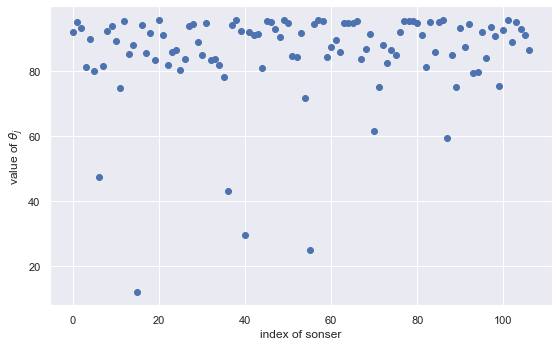

In [41]:
import seaborn as sns
sns.set_theme()
fig, axe =  plt.subplots(1, 1, figsize=(9, 5.5))
axe.plot(list(data.index), theta,linestyle='',marker='o')
axe.set_ylabel("value of $\\theta_j$")
axe.set_xlabel("index of sonser")
plt.savefig("theta.pgf", format='pgf')
plt.show()

In [44]:
# Cette fonction calcule l'estimateur bayésien de beta en se basant sur les loi précédentes
def estim_bayes_beta(y,x,theta0,beta0,tau0,phi,c):
   
    beta_B = np.array([y[i]- estim_bayes_theta(y,x,theta0,tau0,phi,c)[i] for i in range(len(y))]).sum()*np.ones(len(y)) - beta0
                                                                      
    return beta_B

In [45]:
# Cette fonction calcule l'estimateur bayésien de beta en se basant sur les loi précédentes
def estim_bayes_sigma(y,x,theta0,beta0,tau0,phi,c,lamda_0,nu_0):
    n = len(y)
    sigma_B = (np.array([y[i]- estim_bayes_theta(y,x,theta0,tau0,phi,c)[i]- estim_bayes_beta(y,x,theta0,beta0,tau0,phi,c)[i] for i in range(len(y))])).sum()/(nu_0-(n/2)-1)
    return sigma_B
    

Les fonctions qui suivent ont pour but de calculer $\hat{\eta}_{\phi}$. Sachant que $\pi(\eta |y,\phi) = \frac{\pi(\eta|y)}{\pi(\eta)}$ = $\frac{\pi(\eta|y)}{\prod_{i=1}^{k}(|S_{i}|-1)!}$, On déduit rapidement $\hat{\eta}_{\phi}$. k=2 dans notre cas; car nous somme dans le cadre d'une classification où on ne peut avoir que deux clusters.

In [46]:
def prob_phi(phi,c):
    prob_phi = 1
    for i in range(len(phi)):
        prob_phi = prob_phi*np.math.factorial(len(phi[i])-1)
    return c*prob_phi

In [47]:
def estim_phi_theta(y,x,theta0,beta0,tau0,phi,c):
    
    theta_phi = np.divide(estim_bayes_theta(x,y,theta0,tau0,phi,c),prob_phi(phi,c)*np.ones(len(y)))
    
    return theta_phi
    

In [48]:
def estim_phi_beta(y,x,theta0,beta0,tau0,phi,c):
    
    beta_phi = np.divide(estim_bayes_beta(y,x,theta0,beta0,tau0,phi,c),prob_phi(phi,c)*np.ones(len(y)))
    
    return beta_phi

In [49]:
def estim_phi_sigma(y,x,theta0,beta0,tau0,lamda_0,nu_0,phi,c):
    
    sigma_phi = estim_bayes_sigma(y,x,theta0,beta0,tau0,lamda_0,nu_0)/prob_phi(phi,c)*np.ones(len(y))
    
    return sigma_phi

Après avoir eu ces différentes observations, il est question dans la suite de calculer la loss $SC_{ k1,k2,k3}$ comma définie dans l'algorithme. 

In [50]:
def  loss_sc(y,x,theta0,beta0,tau0,lamda_0,nu_0,phi,c,k1,k2,k3):
    n=y.shape[0]
    
    SC = (k1/n)*np.linalg.norm(estim_bayes_theta(x,y,theta0,tau0,phi,c)-estim_phi_theta(y,x,theta0,beta0,tau0,phi,c)) 
    + k2*(estim_bayes_sigma(y,x,theta0,beta0,tau0,phi,c,lamda_0,nu_0) - estim_phi_sigma(y,x,theta0,beta0,tau0,lamda_0,nu_0,phi,c))**2 
    + (k3/2)*np.linalg.norm(estim_bayes_beta(y,x,theta0,beta0,tau0,phi,c)-estim_phi_beta(y,x,theta0,beta0,tau0,phi,c))
    
    return SC ,estim_bayes_theta(x,y,theta0,tau0,phi,c)
    

In [52]:
#loss_sc(y,x,theta0=0,beta0=0,tau0=1000,lamda_0=2,nu_0=1,phi = np.array(range(len(y))),c=12,k1=0.001,k2=0.098,k3=0.9)

Il est question dans la suite d'écrire l'algorithme qui permet de choisir la meilleure partition. Ici, nous indexons les individus de 1,...n comme dans le dataset. n représente le nombre d'individus du datset. On veut déterminer la meilleure partition à 2 éléments. L'algorithme s'arrêtera à un seuil $\epsilon$ fixé.


In [32]:
def clustring_2(y,x,theta0,beta0,tau0,lamda_0,nu_0,c,k1,k2,k3,epsilon):
    n = len(y)
    #initialisation 
    phi0=np.array([range(1,n+1)]) # initiation de la partition
    SC0= loss_sc(y,x,theta0,beta0,tau0,lamda_0,nu_0,phi0,c,k1,k2,k3)
    partition_result = phi0  # initialisation de la partition optimale
    SC_result = SC0 # initialisation de la perte optimale
    
    # first step
    
    for i in range(1,n+1):
        phi = np.array([[ x for x in phi0[0] if x!=i],[i]])
        SC = loss_sc(y,x,theta0,beta0,tau0,lamda_0,nu_0,phi,c,k1,k2,k3)
        if SC<= SC_result : 
            partition_result= phi
            SC_result = SC
   
    # second step
    
    if SC_result!=SC0:  # pour éviter le cas où la partition optimale est la partition initiale
        phi1 = partition_result
        SC1 = SC_result
        #j = 0
        for j in range(len(phi1[0])):
        
            phi = np.array([[ x for x in phi1[0] if x!= phi1[0][j]],phi1[1]+[phi1[0][j]]])
            SC = loss_sc(y,x,theta0,beta0,tau0,lamda_0,nu_0,phi,c,k1,k2,k3)
            if abs(SC-SC1)>epsilon:
                if SC<=SC1 :
                    phi1 = phi
                    SC1 = SC
            else: 
                break
        partition_result = phi1 
        SC_result = SC1
        
    return SC_result,partition_result
    

In [33]:
clustring_2(y,x,theta0=0,beta0=0,tau0=1000,lamda_0=2,nu_0=1,c=12,k1=0.001,k2=0.098,k3=0.9,epsilon=10^-1)

KeyboardInterrupt: 

In [182]:
data.tail(6)

,country,happiness,income,lifeexp,sanitation,water,urbanpopulation,unemployment,literacy,inequality,murder,energy,childmortality,fertility,hiv,foodsupply,population
134,Uzbekistan,5.972364,0.042529,0.479245,1.000000,0.860884,0.038702,0.179549,0.994631,0.403017,0.039800,0.073320,0.175074,0.176860,0.045767,0.451087,0.021912
135,Venezuela,5.568800,0.125460,0.686792,0.945114,0.957447,0.261340,0.072722,0.942282,0.653017,0.204133,0.119168,0.106825,0.181818,0.017617,0.380435,0.022055
136,Vietnam,5.076315,0.042278,0.641509,0.765390,0.855974,0.117769,0.026288,0.914094,0.392241,0.060624,0.032056,0.146884,0.119008,0.044583,0.445652,0.066637
137,Yemen,2.982674,0.016896,0.373585,0.566294,0.515548,0.056076,0.049505,0.536913,0.433190,0.060624,0.014148,0.393917,0.472727,0.003866,0.157609,0.018983
138,Zambia,4.843164,0.025189,0.030189,0.258502,0.364975,0.101124,0.179549,0.484564,0.872845,0.060624,0.030977,0.474036,0.628099,0.173163,0.000000,0.011267
139,Zimbabwe,3.703191,0.010613,0.037736,0.339217,0.453355,0.058573,0.224850,0.782550,0.573276,0.060624,0.037180,0.428042,0.429752,0.214237,0.097826,0.011053


In [184]:
data.loc[139]

country            Zimbabwe
happiness          3.703191
income             0.010613
lifeexp            0.037736
sanitation         0.339217
water              0.453355
urbanpopulation    0.058573
unemployment        0.22485
literacy            0.78255
inequality         0.573276
murder             0.060624
energy              0.03718
childmortality     0.428042
fertility          0.429752
hiv                0.214237
foodsupply         0.097826
population         0.011053
Name: 139, dtype: object